In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re

In [ ]:
arg_component_balance=False
arg_add_new_dataset=False
arg_add_transformer=True


In [10]:
components_path = '/data/nishome/user1/minqi/TSGym/meta/components_add_Transformer.yaml'
import yaml
from sklearn import preprocessing


with open(components_path, 'r') as f:
    components = yaml.safe_load(f)

In [11]:

components = {k: {kk:vv for kk, vv in zip(v, preprocessing.LabelEncoder().fit_transform(v))} for k,v in components.items()}

In [13]:
import joblib
joblib.dump(components,'/data/nishome/user1/minqi/TSGym/meta_cc/components.joblib')

['/data/nishome/user1/minqi/TSGym/meta_cc/components.joblib']

In [14]:
joblib.load('/data/nishome/user1/minqi/TSGym/meta_cc/components.joblib')

{'gym_x_mark': {'False': 0, 'True': 1},
 'gym_series_sampling': {'False': 0, 'True': 1},
 'gym_series_norm': {'None': 1, 'Stat': 3, 'RevIN': 2, 'DishTS': 0},
 'gym_series_decomp': {'None': 3, 'MA': 1, 'MoEMA': 2, 'DFT': 0},
 'gym_channel_independent': {'False': 0, 'True': 1},
 'gym_input_embed': {'inverted-encoding': 0,
  'series-encoding': 1,
  'series-patching': 2},
 'gym_network_architecture': {'Transformer': 2, 'MLP': 1, 'GRU': 0},
 'gym_attn': {'null': 3,
  'self-attention': 4,
  'auto-correlation': 0,
  'sparse-attention': 5,
  'frequency-enhanced-attention': 2,
  'destationary-attention': 1},
 'gym_feature_attn': {'null': 1,
  'self-attention': 2,
  'sparse-attention': 3,
  'frequency-enhanced-attention': 0},
 'gym_encoder_only': {'True': 0},
 'gym_frozen': {'False': 0},
 'sequence_length': {'48': 1, '96': 3, '192': 0, '512': 2},
 'd_model': {'64': 1, '256': 0},
 'd_ff': {'256': 1, '1024': 0},
 'encoder layers': {'2': 0, '3': 1},
 'training epochs': {'10': 0, '20': 1, '50': 2},


In [ ]:
components = {k: {kk:vv for kk, vv in zip(v, preprocessing.LabelEncoder().fit_transform(v))} for k,v in components.items()}
components

ValueError: y should be a 1d array, got an array of shape () instead.

In [ ]:
result_path = './results_mae'
# datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'ili', 'weather', 'ECL', 'Exchange', 'traffic']
datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'ili', 'weather', 'Exchange']
if arg_add_new_dataset:
    datasets.extend(['covid-19', 'fred-md'])

pred_len_1, pred_len_2 = 96, 24
file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]

# baselines = [
#  'iTransformer',
#  'MambaSimple',
#  'PatchTST',
#  'TimeMixer',
#  'Koopa',
#  'SegRNN',
#  'DLinear',
#  'FEDformer',
#  'Crossformer',
#  'Informer',
#  'PAttn',
#  'ETSformer',
#  'TimeXer',
#  'LightTS',
#  'Nonstationary',
#  'TiDE',
#  'Pyraformer',
#  'MICN',
#  'Transformer',
#  'FiLM',
#  'TimesNet',
#  'TSMixer',
#  'Autoformer',
#  'Reformer',
#  'DUET']
print(len(file_list))

7


In [4]:
# sota performance
def search_sota_performance(dataset, pred_lens=[96],
                            path_old='/data/nishome/user1/minqi/TSGym/results', 
                            path='/data/nishome/user1/minqi/TSGym/results_long_term_forecasting/results'):
    result_dict = {}
    for pred_len in pred_lens:
        model_list_old = os.listdir(path_old)
        model_list_old = [_ for _ in model_list_old if f'pl{pred_len}' in _ and dataset in _]

        try:
            model_list_new = os.listdir(os.path.join(path, dataset))
            model_list_new = [_ for _ in model_list_new if f'pl{pred_len}' in _]
        except:
            model_list_new = []
        model_list = model_list_old + model_list_new

        result_dict[pred_len] = {}
        for model in model_list:
            try:
                result = np.load(os.path.join(path_old, model, 'metrics.npy'), allow_pickle=True)
            except:
                result = np.load(os.path.join(path, dataset, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]

    df = pd.DataFrame.from_dict(result_dict[pred_lens[0]], orient='index')
    df.columns = ['mse']
    df = df.sort_values(by='mse')
    df.index = [_.split('_')[1] if 'LTF' in _ or 'STF' in _ else _.split('_')[6] for _ in df.index]

    return df

In [5]:
dfs_rank = []; dfs_dict = {}
for pred_len_1, pred_len_2 in zip([96, 192, 336, 720], [24, 36, 48, 60]):
    file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]
    dfs = []
    for i, file in enumerate(file_list):
        # dataset = file.split('-')[0]
        dataset = file[:re.search('-component', file).start()]

        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[pred_len_2])
        else:
            df = search_sota_performance(dataset, pred_lens=[pred_len_1])

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']

        df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
        df.dropna(inplace=True)
        df = df.sort_values(by='mse')
        df = df.reset_index()
        df.columns = ['model', dataset]
        # todo: 有重复, 并且跑出来结果还不同
        df = df.drop_duplicates(subset='model', keep='first')
        df = df.set_index('model')
        dfs.append(df)

    dfs = pd.concat(dfs, axis=1)
    dfs_dict[pred_len_1] = dfs

baselines = pd.concat(list({k: v.rename(columns=lambda col: f"{col}_{k}") for k, v in dfs_dict.items()}.values()), axis=1).dropna().index
baselines = list(baselines)
print(baselines)

['DUET', 'SegRNN', 'PatchTST', 'TimeMixer', 'TimeXer', 'TiDE', 'TSGym', 'iTransformer', 'PAttn', 'DLinear', 'FreTS', 'FEDformer', 'FiLM', 'MICN', 'Crossformer', 'Autoformer', 'LightTS', 'SCINet', 'TSMixer', 'Mamba', 'Nonstationary', 'ETSformer', 'TemporalFusionTransformer', 'Pyraformer', 'Transformer', 'Reformer', 'Informer']


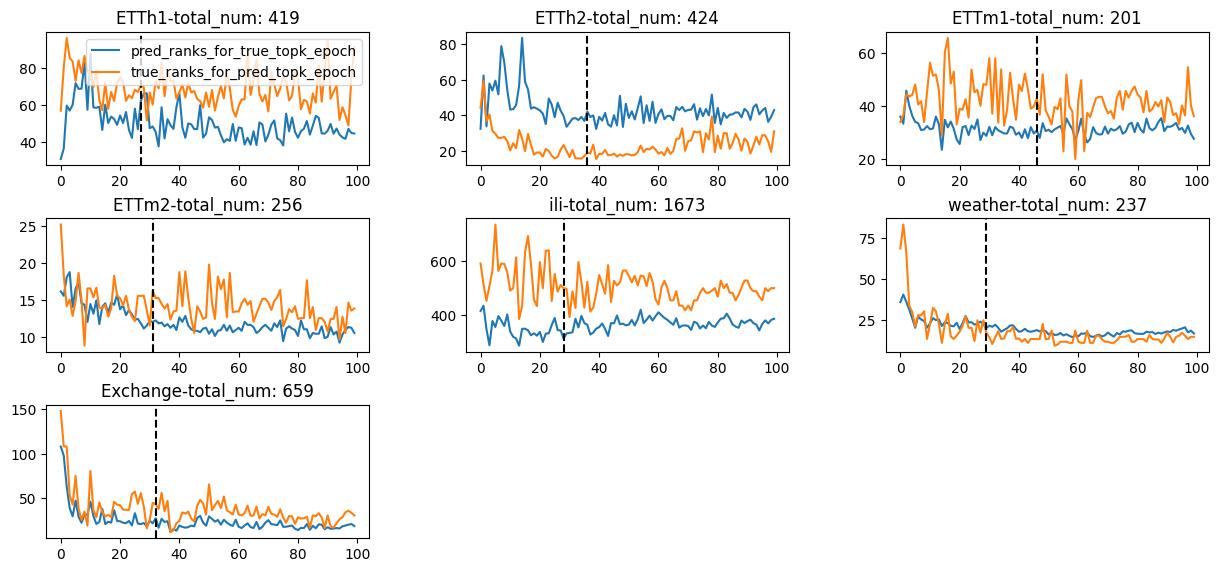

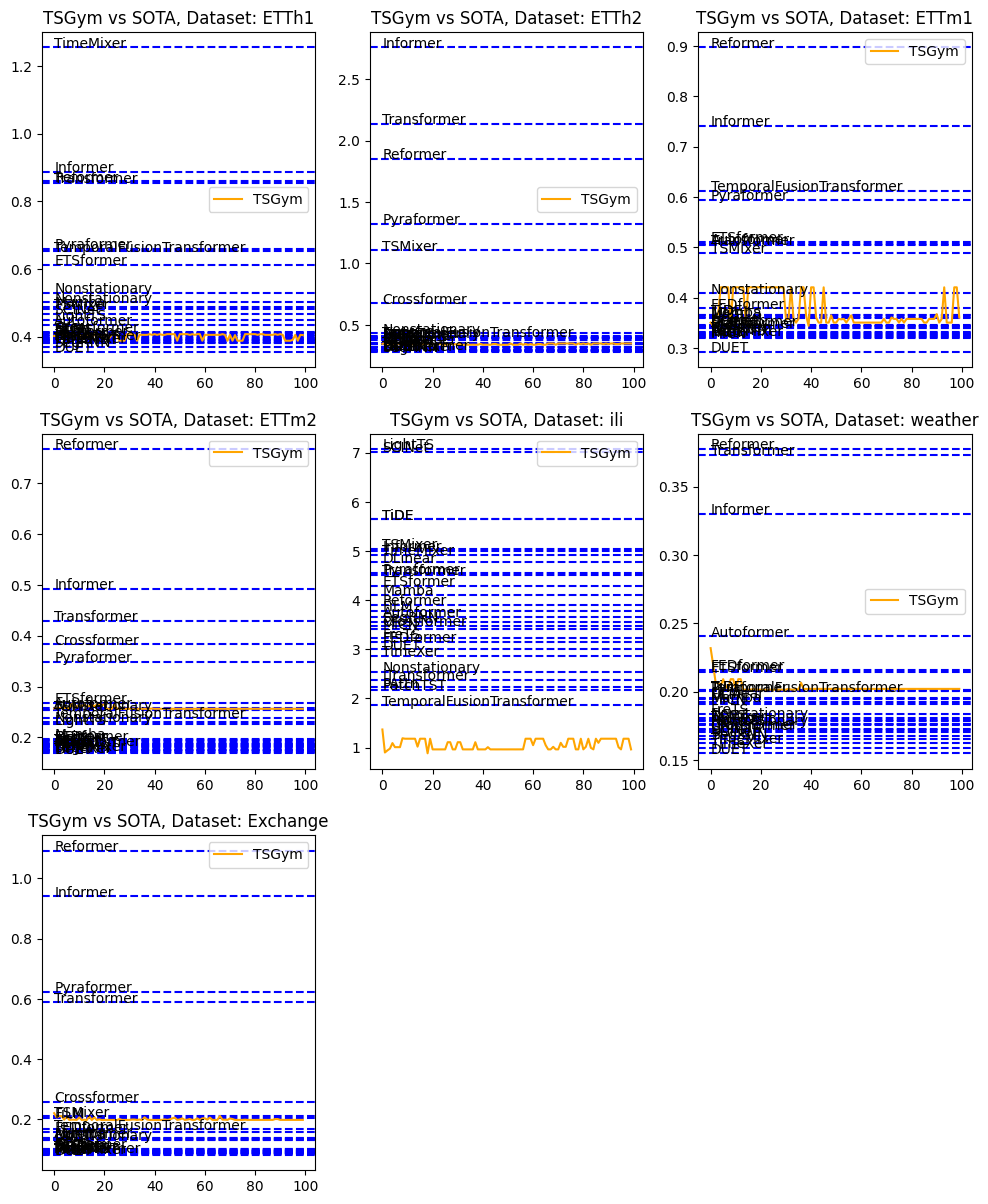

In [6]:
pred_len_1, pred_len_2 = 96, 24
file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]


fig = plt.figure(figsize=(15, 9))
for i, file in enumerate(file_list):
    # perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
    try:
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        # print(perf_epoch.files)

        fig.add_subplot(4, 3, i+1)
        for _ in perf_epoch.files:
            if _ in ['pred_ranks_for_true_topk_epoch', 'true_ranks_for_pred_topk_epoch']:
                plt.plot(perf_epoch[_], label=_)
            elif _ == 'total_num':
                plt.title(f'{file.replace(".npz", "").split("-")[0]}-total_num: {perf_epoch[_]}')
            elif _ == 'best_epoch':
                plt.axvline(perf_epoch['best_epoch'].item(), color='black', linestyle='--')
            else:
                pass 

        if i==0: plt.legend()
    except:
        continue

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

fig = plt.figure(figsize=(12, 20))
for i, file in enumerate(file_list):
    try:
        dataset = file[:re.search('-component', file).start()]
        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[24])
        else:
            df = search_sota_performance(dataset, pred_lens=[96])
        # except:
        #     continue
        fig.add_subplot(4, 3, i+1)
        for model, metric in df.iterrows():
            if model not in baselines: continue
            plt.axhline(y=metric.item(), color='blue', linestyle='--')
            plt.text(0, metric.item(), model, color='black')

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']
        plt.plot(top1_perf_epoch, color='orange', label='TSGym')

        plt.legend()
        plt.title(f'TSGym vs SOTA, Dataset: {dataset}')
    except:
        continue

plt.show()

In [7]:
# TSGym vs best sota
dfs_rank = []; dfs_dict = {}
for pred_len_1, pred_len_2 in zip([96, 192, 336, 720], [24, 36, 48, 60]):
    file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]
    dfs = []
    for i, file in enumerate(file_list):
        # dataset = file.split('-')[0]
        dataset = file[:re.search('-component', file).start()]

        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[pred_len_2])
        else:
            df = search_sota_performance(dataset, pred_lens=[pred_len_1])

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']

        df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
        df.dropna(inplace=True)
        df = df.loc[baselines]
        df = df.sort_values(by='mse')
        df = df.reset_index()
        df.columns = ['model', dataset]
        # todo: 有重复, 并且跑出来结果还不同
        df = df.drop_duplicates(subset='model', keep='first')
        df = df.set_index('model')
        dfs.append(df)

    model_names = set.intersection(*map(set, [_.index.tolist() for _ in dfs]))
    for i, df in enumerate(dfs):
        df = df[[_ in model_names for _ in df.index]]
        dfs[i] = df.sort_values(by=df.columns[0])

    ranks = {k: [] for k in baselines}
    ranks['TSGym'] = []
    for df in dfs:
        for baseline in baselines:
            if len(np.where(df.index == baseline)[0]) > 0:
                ranks[baseline].append((np.where(df.index == baseline)[0] + 1).item())
        ranks['TSGym'].append((np.where(df.index == 'TSGym')[0] + 1).item())

    dfs = pd.concat(dfs, axis=1)
    dfs = dfs.round(4)
    dfs.index = dfs.index.str.replace('TemporalFusionTransformer', 'TFT')
    dfs_dict[pred_len_1] = dfs
    # dfs.to_excel(f'./meta/results_paper/perf_component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.xlsx', index=True)
    
    df_rank = pd.Series({k: np.mean(v) for k,v in ranks.items() if len(v) > 0})
    df_rank = df_rank.sort_values()
    dfs_rank.append(df_rank)

dfs_rank = pd.concat(dfs_rank, axis=1)
dfs_rank.columns = [str(_) for _ in [96, 192, 336, 720]]
dfs_rank.index = dfs_rank.index.str.replace('TemporalFusionTransformer', 'TFT')
dfs_rank = dfs_rank.round(2)
# dfs_rank.to_excel(f'./meta/results_paper/rank_component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.xlsx', index=True)

In [10]:
dfs_dict[96]

,ETTh1,ETTh2,ETTm1,ETTm2,ili,weather,Exchange
model,,,,,,,
DUET,0.3559,0.2899,0.2929,0.1687,2.9996,0.1548,0.0800
SegRNN,0.3709,0.2826,0.3306,0.1729,3.5645,0.1656,0.0915
PatchTST,0.3802,0.2950,0.3272,0.1819,2.1682,0.1757,0.0866
TimeMixer,0.3816,0.2911,0.3240,0.1743,4.9236,0.1626,0.0836
TimeXer,0.3838,0.2874,0.3318,0.1706,2.8691,0.1587,0.0873
TiDE,0.3850,0.3191,0.3663,0.1879,5.6437,0.2009,0.0929
TSGym,0.3880,0.3389,0.3505,0.2562,0.9643,0.2014,0.1982
iTransformer,0.3911,0.3010,0.3442,0.1837,2.3849,0.1725,0.0883
PAttn,0.3912,0.2970,0.3217,0.1799,2.2270,0.1761,0.0855


In [14]:
dfs_rank

,96,192,336,720
DUET,2.14,6.43,6.71,7.71
TimeXer,3.43,3.71,4.86,5.71
SegRNN,4.43,4.43,6.29,7.14
PAttn,4.71,6.00,6.71,7.57
iTransformer,6.00,5.71,6.29,7.57
MICN,9.14,10.14,10.71,11.00
FreTS,9.57,10.57,10.57,12.29
FiLM,10.00,7.43,6.29,5.14
TSGym,11.14,9.43,6.57,3.57
TiDE,11.29,10.14,10.43,9.57


meta-feature的差异性

In [22]:
# meta_feature_path = '/data/coding/chaochuan/TSGym/meta_learner_cc/meta_feature_copy/meta_feature'

In [23]:
# meta_features_dict = {}
# for file in os.listdir(meta_feature_path):
#     if file.endswith('.npz'):
#         meta_feature = np.load(os.path.join(meta_feature_path, file), allow_pickle=True)
#         meta_features_dict[file.replace('.npz', '').replace('meta_feature_', '')] = meta_feature['meta_feature']

In [24]:
# meta_features = np.stack(list(meta_features_dict.values()))
# meta_features = np.clip(meta_features, -1e4, 1e4)

# # z-score
# mu = np.nanmean(meta_features, axis=0, keepdims=True)
# std = np.nanstd(meta_features, axis=0, keepdims=True)

# meta_features = (meta_features - mu) / (std + 1e-6)
# meta_features = np.nan_to_num(meta_features, nan=0.0)

In [25]:
# fig = plt.figure(figsize=(20, 20))

# for seed in range(1, 5):
#     tsne = TSNE(n_components=2, random_state=seed, perplexity=10)
#     meta_features_tsne = tsne.fit_transform(meta_features) 
#     meta_features_dict_tsne = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_tsne)}
#     fig.add_subplot(2, 2, seed)
#     for k, v in meta_features_dict_tsne.items():
#         plt.scatter(v[0], v[1])
#         plt.text(v[0], v[1], k, fontsize=12)
# fig.suptitle('TSNE', fontsize=16)
# plt.show()


In [26]:
# fig = plt.figure(figsize=(20, 20))

# pca = PCA(n_components=2, random_state=42)
# meta_features_pca = pca.fit_transform(meta_features) 
# meta_features_dict_pca = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_pca)}
# for k, v in meta_features_dict_pca.items():
#     plt.scatter(v[0], v[1])
#     plt.text(v[0], v[1], k, fontsize=16)
# plt.title('PCA', fontsize=16)
# plt.show()
